# Proyecto 1. Entrega 2.
# Algoritmos de Aprendizaje no Supervisado

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import bartlett
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from mlxtend.frequent_patterns import apriori, association_rules

## 1. Clustering

### 1.1. Preprocesamiento del dataset

In [12]:
# Cargar el dataset
try:
    df = pd.read_csv('movies.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        df = pd.read_csv('movies.csv', encoding='latin-1')  
    except UnicodeDecodeError:
        df = pd.read_csv('movies.csv', encoding='utf-8', errors='replace')

# Eliminar columnas irrelevantes
drop_columns = ['id', 'originalTitle', 'title', 'homePage', 'actorsCharacter', 'video']
df = df.drop(columns=drop_columns)

# Codificación one-hot para variables categóricas
categorical_cols = ['originalLanguage', 'productionCompanyCountry']
df = pd.get_dummies(df, columns=categorical_cols)

# Normalización de variables numéricas
scaler = StandardScaler()
numerical_cols = ['popularity', 'budget', 'revenue', 'runtime', 'voteCount', 'voteAvg', 'actorsPopularity', 'actorsAmount', 'castWomenAmount', 'castMenAmount', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount']
# Convertir a números y manejar errores
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Llenar NaN con la mediana
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Normalización
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


### 1.2. Análisis de tendencia al agrupamiento

Nota: pyclustertend no es compatible con mi version de numpy

Hopkins Statistic: 0.9863985214971532


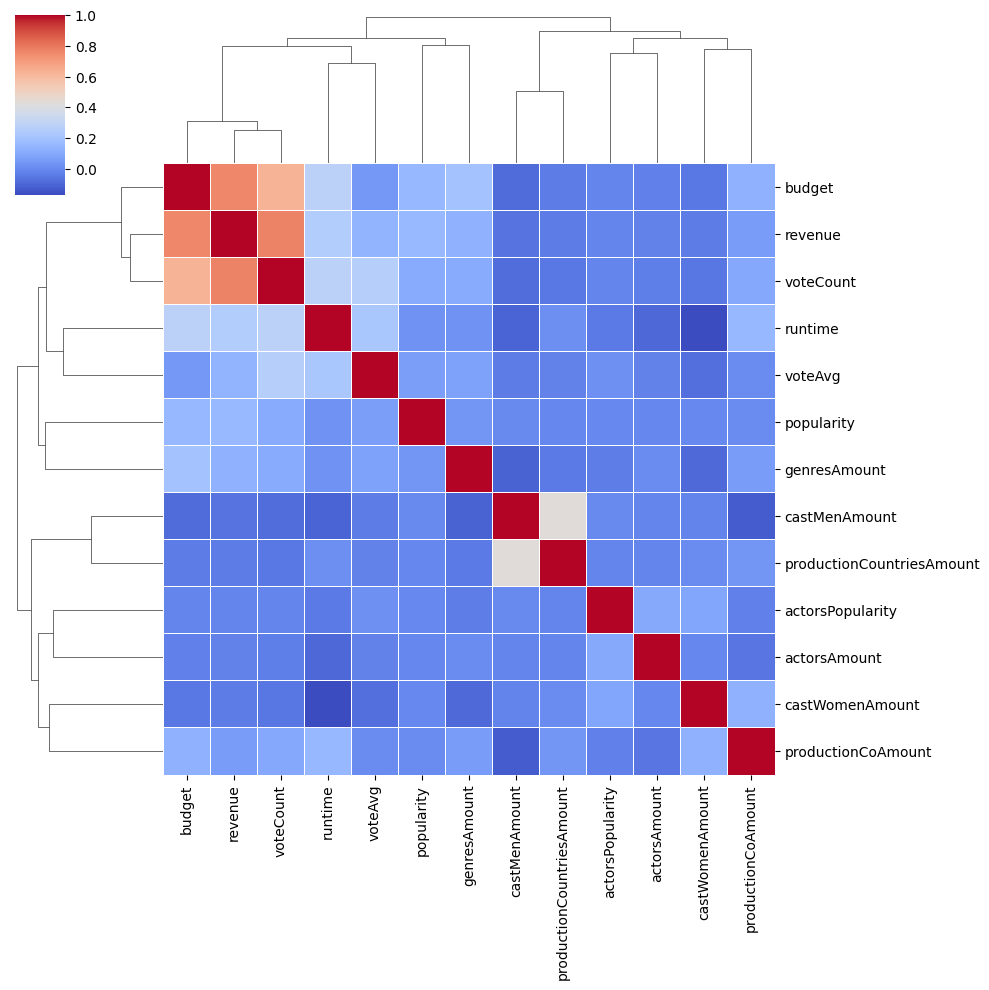

In [19]:
# Function to compute Hopkins statistic
def hopkins_statistic(X, sample_size=50):
    n, d = X.shape
    sample_size = min(sample_size, n)
    
    # Randomly select sample points
    np.random.seed(42)
    sample_indices = np.random.choice(n, sample_size, replace=False)
    sample_points = X[sample_indices]

    # Nearest neighbors for sample and random points
    nn = NearestNeighbors(n_neighbors=2).fit(X)
    distances_sample, _ = nn.kneighbors(sample_points)
    distances_random, _ = nn.kneighbors(np.random.uniform(X.min(axis=0), X.max(axis=0), (sample_size, d)))

    return np.sum(distances_random[:, 0]) / (np.sum(distances_random[:, 0]) + np.sum(distances_sample[:, 1]))

# Compute Hopkins statistic
hopkins_value = hopkins_statistic(df[numerical_cols].select_dtypes(include=np.number).values)
print(f"Hopkins Statistic: {hopkins_value}")

# Use Seaborn's clustermap as VAT alternative
sns.clustermap(df[numerical_cols].select_dtypes(include=np.number).corr(), cmap="coolwarm", linewidths=0.5)
plt.show()

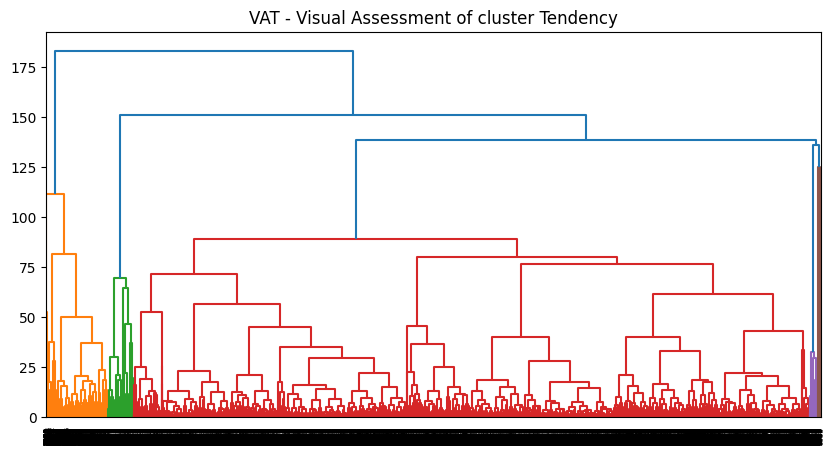

In [20]:
# VAT (Visual Assessment of cluster Tendency)
Z = linkage(df[numerical_cols], method='ward')
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.title('VAT - Visual Assessment of cluster Tendency')
plt.show()

### 1.3. Determinación del número óptimo de clústeres

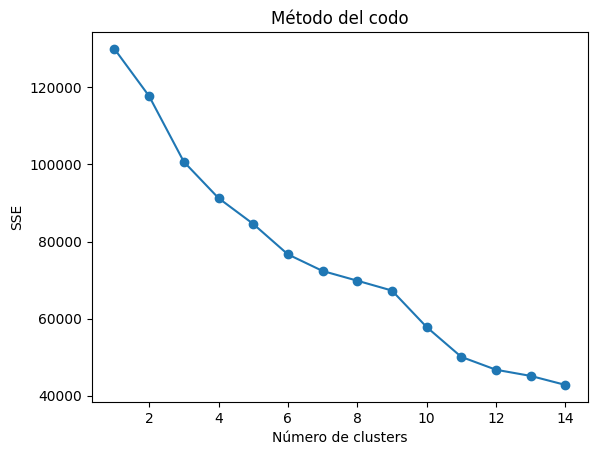

In [14]:
sse = []
k_values = range(1, 15)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df[numerical_cols])
    sse.append(kmeans.inertia_)

plt.plot(k_values, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('Método del codo')
plt.show()


### 1.4. Utilice los algoritmos k-medias y clustering jerárquico para agrupar. Compare los resultados generados por cada uno.

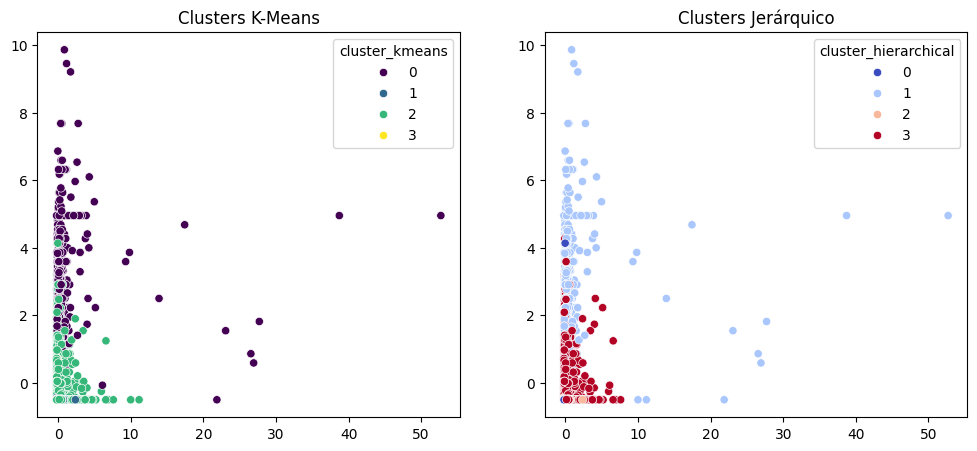

In [ ]:
movies_numeric = df[numerical_cols].dropna()
movies_scaled = scaler.fit_transform(movies_numeric)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
movies_numeric["cluster_kmeans"] = kmeans.fit_predict(movies_scaled)

# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
movies_numeric["cluster_hierarchical"] = hierarchical.fit_predict(movies_scaled)

# Comparación de los clusters
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=movies_scaled[:, 0], y=movies_scaled[:, 1], hue=movies_numeric["cluster_kmeans"], palette="viridis")
plt.title("Clusters K-Means")

plt.subplot(1, 2, 2)
sns.scatterplot(x=movies_scaled[:, 0], y=movies_scaled[:, 1], hue=movies_numeric["cluster_hierarchical"], palette="coolwarm")
plt.title("Clusters Jerárquico")

plt.show()

### 1.5. Evaluación de calidad con el método de la silueta

In [ ]:
# Calcular la calidad del agrupamiento con el método de la silueta
silhouette_kmeans = silhouette_score(movies_scaled, movies_numeric["cluster_kmeans"])
silhouette_hierarchical = silhouette_score(movies_scaled, movies_numeric["cluster_hierarchical"])
print(f"Silhouette Score - K-Means: {silhouette_kmeans:.4f}")
print(f"Silhouette Score - Clustering Jerárquico: {silhouette_hierarchical:.4f}")

Silhouette Score - K-Means: 0.5019
Silhouette Score - Clustering Jerárquico: 0.4920


### 1.6. Interpretación de los grupos

In [ ]:
# Aplicar K-Means con 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
movies_numeric = movies_numeric.copy()  # Asegurar que no se sobrescriba el DataFrame original
movies_numeric["cluster_kmeans"] = kmeans.fit_predict(movies_scaled)

# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
movies_numeric["cluster_hierarchical"] = hierarchical.fit_predict(movies_scaled)

# Ahora sí se pueden agrupar por cluster
summary_kmeans = movies_numeric.groupby("cluster_kmeans")[numerical_cols].agg(["mean", "median", "std"])
summary_hierarchical = movies_numeric.groupby("cluster_hierarchical")[numerical_cols].agg(["mean", "median", "std"])

# Mostrar los resultados
print("\nResumen de Clusters K-Means:")
print(summary_kmeans)

print("\nResumen de Clusters Jerárquico:")
print(summary_hierarchical)


Resumen de Clusters K-Means:
               popularity                        budget                      \
                     mean    median       std      mean    median       std   
cluster_kmeans                                                                
0                0.642454  0.106396  3.313537  2.523644  2.305766  1.710327   
1               -0.020947 -0.131553  0.341935 -0.499211 -0.506531  0.059873   
2               -0.053102 -0.142308  0.392224 -0.195122 -0.506531  0.537973   
3               -0.114403 -0.118748  0.060489 -0.468135 -0.506531  0.217201   

                 revenue                       runtime  ... castMenAmount  \
                    mean    median       std      mean  ...           std   
cluster_kmeans                                          ...                 
0               2.561833  1.974732  2.181501  0.815471  ...      0.256075   
1              -0.362389 -0.379320  0.270891 -0.641125  ...      2.330475   
2              -0.203193 -0.379

# 2.1. Reglas de Asociación con Apriori

In [23]:
df_discretized = df[numerical_cols].copy()

for col in df[numerical_cols].columns:
    # Obtener los bins sin etiquetas para verificar cuántos hay realmente
    _, bins = pd.qcut(df[numerical_cols][col], q=4, retbins=True, duplicates="drop")

    # Generar etiquetas dinámicamente según el número real de bins
    labels = ["Bajo", "Medio", "Alto", "Muy Alto"][: len(bins) - 1]

    # Aplicar qcut con las etiquetas correctas
    df_discretized[col] = pd.qcut(df[numerical_cols][col], q=4, labels=labels, duplicates="drop")


# Transformar los datos para apriori
df_apriori = pd.get_dummies(df_discretized)
frequent_itemsets = apriori(df_apriori, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules.sort_values(by="lift", ascending=False))

                                             antecedents  \
38875       (castMenAmount_Muy Alto, voteCount_Muy Alto)   
38850  (revenue_Alto, popularity_Muy Alto, actorsAmou...   
38864  (revenue_Alto, popularity_Muy Alto, actorsAmou...   
38861  (castMenAmount_Muy Alto, voteCount_Muy Alto, a...   
21392  (revenue_Alto, popularity_Muy Alto, actorsAmou...   
...                                                  ...   
10674                            (actorsPopularity_Bajo)   
14904  (genresAmount_Bajo, voteAvg_Muy Alto, actorsPo...   
14878  (genresAmount_Bajo, voteAvg_Alto, actorsPopula...   
14909                                     (revenue_Bajo)   
14881                                     (revenue_Bajo)   

                                             consequents  antecedent support  \
38875  (revenue_Alto, popularity_Muy Alto, actorsAmou...              0.1165   
38850       (castMenAmount_Muy Alto, voteCount_Muy Alto)              0.0650   
38864  (castMenAmount_Muy Alto, voteCou

### 3.2. Evaluación de la viabilidad del PCA

In [ ]:
# Prueba de esfericidad de Bartlett
chi_square_value, p_value = bartlett(*[movies_numeric[col] for col in numerical_cols])

print(f"\nPrueba de Bartlett - Chi-Square: {chi_square_value:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Los datos son adecuados para PCA.")
else:
    print("Los datos no son adecuados para PCA.")


Prueba de Bartlett - Chi-Square: -0.0000, p-value: 1.0000
Los datos no son adecuados para PCA.


### 3.3. Análisis de Componentes Principales (PCA)

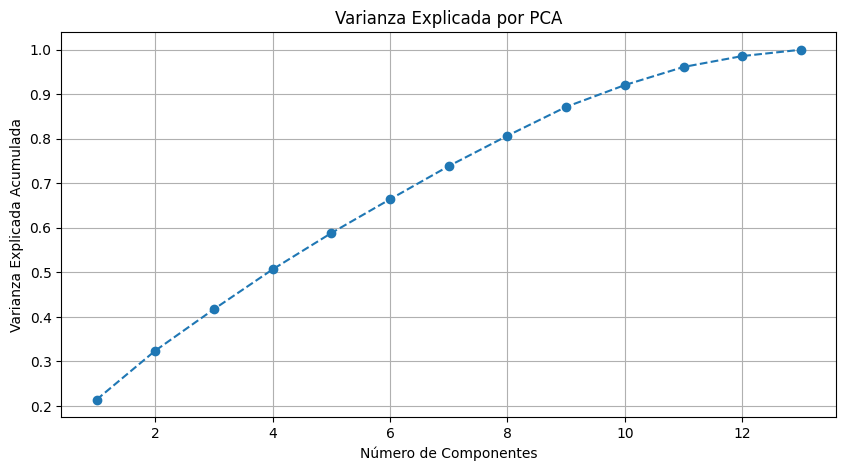

(8,
       popularity    budget   revenue   runtime  voteCount   voteAvg  \
 PC1     0.140891  0.504716  0.527365  0.289296   0.513856  0.184763   
 PC2     0.070453  0.072001  0.106929  0.020083   0.081084  0.009019   
 PC3     0.122803  0.179881  0.183919 -0.392201   0.091624 -0.331550   
 PC4    -0.123903 -0.008327 -0.081660  0.196469  -0.048739 -0.116138   
 PC5    -0.127798 -0.184582 -0.116675  0.343071   0.030697  0.584425   
 PC6    -0.365778  0.047477 -0.069995  0.007542  -0.078994 -0.106201   
 PC7     0.804108 -0.112183 -0.144308 -0.094613  -0.151207  0.287051   
 PC8     0.315921  0.007604 -0.039984  0.249601  -0.058481 -0.214827   
 PC9     0.204708  0.102387 -0.046919  0.257695  -0.152766 -0.508878   
 PC10    0.029501  0.032271 -0.063431  0.646367  -0.160401 -0.187438   
 PC11   -0.014651  0.020657 -0.037032  0.202804  -0.059076 -0.027442   
 PC12   -0.069002  0.697341 -0.026574 -0.088497  -0.647993  0.256311   
 PC13   -0.021934 -0.400559  0.787858  0.036296  -0.461184  

In [ ]:
# Filtrar dataset con solo las columnas numéricas relevantes
movies_numeric = df[numerical_cols].dropna()

# Normalizar los datos para PCA
scaler = StandardScaler()
movies_scaled = scaler.fit_transform(movies_numeric)

# --- 3.3: Análisis de Componentes Principales (PCA) ---

# Aplicar PCA a todas las variables numéricas
pca = PCA()
movies_pca_full = pca.fit_transform(movies_scaled)

# Explicación de varianza por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

# Crear un gráfico de varianza explicada acumulada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Varianza Explicada por PCA")
plt.grid()
plt.show()

# Determinar cuántos componentes explican al menos el 80% de la varianza
num_components_80 = np.argmax(np.cumsum(explained_variance_ratio) >= 0.80) + 1

# Cargar las cargas factoriales de los componentes principales
componentes_df = pd.DataFrame(pca.components_, columns=numerical_cols, index=[f'PC{i+1}' for i in range(len(numerical_cols))])

# Mostrar los resultados
num_components_80, componentes_df